## Imports

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import UnivariateSpline
import h5py
import astropy
import astropy.cosmology as cosmo
import astropy.units as u
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import json
import glob
import re
import cupy as xp
import pandas as pd
import bilby
import gwpopulation as gwpop
from bilby.core.prior import Uniform, PriorDict
from gwpopulation.models import mass, spin
import seaborn as sns
from mpl_toolkits.mplot3d import axes3d
from scipy.interpolate import griddata

xp = gwpop.cupy_utils.xp

### Functions 

Here, $q = \frac{m_2}{m_1}$

$$\chi_{\mathrm{eff}} = \frac{a_1 cost_1 + a_2 q cos t_2}{1 + q}$$

$$\chi_{\mathrm{p}} = max \bigg[a_1sint_1 , \bigg(\frac{4q + 3}{4 + 3q}\bigg)q a_2sint_2\bigg]$$


$$p_{LAL}(m_1, m_2, z) \propto (1+z)^2 D_L(z)^2  \bigg[ D_c(z) + \frac{c(1+z)}{H(z)}\bigg]$$

$$p_{astro}(m_1, m_2, z) \propto \frac{1}{(1+z)} (1+z)^{2.7} \frac{dV_c}{dz} m_1^{-2.2} q^{1.3}$$

To calculate $\frac{dV_c}{dz}$ :  https://docs.astropy.org/en/stable/_modules/astropy/cosmology/core.html

To calculate Hubble Parameter https://docs.astropy.org/en/stable/_modules/astropy/cosmology/core.html

In [2]:
def chieff(a1, a2, q, cost1, cost2):
    chi_eff = (a1*cost1 + a2*q*cost2)/(1.0 + q)
    return chi_eff

def chiP(a1, a2, q, cost1, cost2):
    term1 = a1 * np.sin(np.arccos(cost1))
    term2 = ((4.0*q + 3.0)/(4.0 + 3.0*q)) * q * a2 * np.sin(np.arccos(cost2))
    return np.max([term1, term2], axis = 0)


def H(z):
    omega_m = Planck15.Om0                                            # 0.3156-used by tom     # unitless
    h_0 = Planck15.H(0).to('m/(Mpc*s)').value                           # m/Mpc/s
    h_z = h_0 * np.sqrt(omega_m * (1.0 + z)**3.0 + (1.0 - omega_m))   # m/Mpc-s
    return h_z
    
def LAL_prior(z, d_l):
    d_c = d_l/(1.0 + z)                                                        # Mpc
    c = astropy.constants.c.value                                              # m/s
    priorLAL = (1.0 + z)**2.0 * d_l**2.0 * (d_c + (c * (1.0 + z)/H(z)))
    return priorLAL

def astro_prior(m1, m2, z, d_l):
    
    # **Source frame** masses should be given as input (m1 and m2)
    
    alpha = -2.2
    beta = 1.3
    Mmin = 5.0
    Mmax = 75.0
    
    d_c = d_l/(1.0 + z)                                                        # Mpc
    c = astropy.constants.c.value                                              # m/s    
    dVc_dz = 4.0 * np.pi * c * (d_c**2.0) / H(z)
    
    pz = (1.0 + z)**1.7 * dVc_dz
    pm1 = m1**alpha
    pm2 = m2**beta / ((m1**(1.0 + beta)) - (Mmin**(1.0 + beta)))
    
    priorASTRO = pz*pm1*pm2
    priorASTRO[m2 < Mmin] = 0.0
    priorASTRO[m1 > Mmax] = 0.0
    
    return priorASTRO

Redshift Interpolant

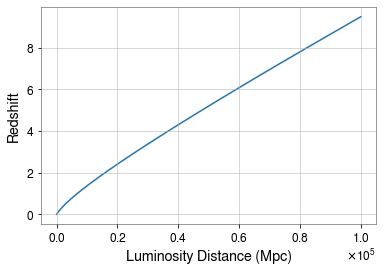

In [3]:
luminosity_distances = np.linspace(1, 100000, 1000)
redshifts = np.array([cosmo.z_at_value(Planck15.luminosity_distance, 
                                                   dl * u.Mpc) for dl in luminosity_distances])
dl_to_z = interp1d(luminosity_distances, redshifts)

plt.plot(luminosity_distances, redshifts)
plt.xlabel("Luminosity Distance (Mpc)")
plt.ylabel("Redshift")
plt.show()

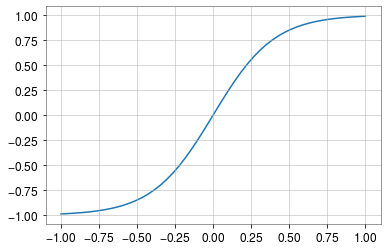

In [4]:
# Logistic transform:

def logistic(x):
    return 2.0/(1.0 + np.exp(-5.0*x))-1
    
x = np.linspace(-1,1)
plt.plot(x,logistic(x))
plt.show()

In [5]:
def interpolants(prior_samples, demo = False):
    
    
    # Construct KDEs
    # 1D priors
    chi_eff_prior_kde = gaussian_kde(prior_samples["chieff"])
    chi_p_prior_kde = gaussian_kde(prior_samples["chip"])
    # 2D priors
    joint_prior_kde = gaussian_kde(np.array([logistic(prior_samples["chieff"]), prior_samples["chip"]]), 
                                   bw_method = 0.5 * prior_samples["chieff"].size**(-1.0/6.0))  # bw-method?
    
    
    # Construct chi_eff prior interpolant
    chi_eff_array = np.concatenate(([-1], np.arange(-0.99, 1.00, 0.01), [1]))
    prob_chi_eff_array = np.concatenate(([0.00], chi_eff_prior_kde(np.arange(-0.99, 1.00, 0.01)), [0]))
    chi_eff_norm = np.trapz(prob_chi_eff_array, chi_eff_array)
    chi_eff_interpolant = interp1d(chi_eff_array, prob_chi_eff_array/chi_eff_norm, kind = 'cubic')
    
    
    # Construct chi_p prior interpolant
    chi_p_array = np.concatenate(([0], np.arange(0.02, 1.00, 0.02), [0.99], [1]))
    prob_chi_p_array = np.concatenate(([0], chi_p_prior_kde(np.arange(0.02, 1.00, 0.02)), chi_p_prior_kde(0.99), [0]))
    chi_p_norm = np.trapz(prob_chi_p_array, chi_p_array)
    chi_p_interpolant = interp1d(chi_p_array, prob_chi_p_array/chi_p_norm, kind = 'cubic')
    
    
    # Construct XY grid for 2D joint prior spline
    x = np.concatenate([np.arange(-1.00, -0.20, 0.1), np.arange(-0.2, 0.2, 0.02), np.arange(0.2, 1.1, 0.1)])
    y = np.concatenate([[0.00], np.arange(0.02, 0.10, 0.01), np.arange(0.1,1.05,0.05)])
    X,Y = np.meshgrid(x, y)
    joint_prob = joint_prior_kde([X.reshape(-1), Y.reshape(-1)])
    joint_prob_2d = joint_prob.reshape(y.size, x.size)
    joint_prob_2d[0, :] = 0.00
    joint_prob_2d[-1, :] = 0.00
    joint_prob_2d[:, 0] = 0.00
    joint_prob_2d[:, -1] = 0.00
    joint_prior_spline = RectBivariateSpline(x, y, joint_prob_2d.T, kx = 2, ky =  2)
    
    if demo == True:
        return chi_eff_interpolant, chi_p_interpolant, joint_prior_spline, x, y, joint_prob_2d
    else: 
        return chi_eff_interpolant, chi_p_interpolant, joint_prior_spline
    

def evaluate_joint_prior(chi_eff_samples, chi_p_samples, joint_prior_spline):
    joint_priors_logistic_chieff = joint_prior_spline.ev(logistic(chi_eff_samples), chi_p_samples)
    joint_priors = joint_priors_logistic_chieff * (2.0*5.0*np.exp(-5.0*chi_eff_samples))/np.square(1.0 + np.exp(-5.0*chi_eff_samples))
    return joint_priors 

## Posteriors

In [7]:
## Only run this to load priors and posteriors if they have already been calculated

posteriors = []
priors = []

i = 0
for filename in glob.glob('./preprocessed_events/posteriors/*'):
    print(i, filename)
    i = i+1
    _posterior = pd.read_csv(filename)
    posteriors.append(_posterior)
    
i = 0
for filename in glob.glob('./preprocessed_events/priors/*'):
    print(i, filename)
    i = i+1
    _prior = pd.read_csv(filename)
    priors.append(_prior)

0 ./preprocessed_events/posteriors/S190519bj.csv
1 ./preprocessed_events/posteriors/S190413ac.csv
2 ./preprocessed_events/posteriors/S190930s.csv
3 ./preprocessed_events/posteriors/S190517h.csv
4 ./preprocessed_events/posteriors/S190706ai.csv
5 ./preprocessed_events/posteriors/S190828l.csv
6 ./preprocessed_events/posteriors/S190412m.csv
7 ./preprocessed_events/posteriors/S190924h.csv
8 ./preprocessed_events/posteriors/S190602aq.csv
9 ./preprocessed_events/posteriors/GW170729.csv
10 ./preprocessed_events/posteriors/S190421ar.csv
11 ./preprocessed_events/posteriors/S190728q.csv
12 ./preprocessed_events/posteriors/S190910s.csv
13 ./preprocessed_events/posteriors/S190727h.csv
14 ./preprocessed_events/posteriors/GW170814.csv
15 ./preprocessed_events/posteriors/S190828j.csv
16 ./preprocessed_events/posteriors/S190731aa.csv
17 ./preprocessed_events/posteriors/S190630ag.csv
18 ./preprocessed_events/posteriors/S190707q.csv
19 ./preprocessed_events/posteriors/GW150914.csv
20 ./preprocessed_event

In [8]:
for prior in priors:
    prior["prior"] = prior["joint_prior"] * prior["weights"]

In [ ]:
for prior in priors:
    sns.distplot(prior["prior"], bins = 50)
    plt.show()

## Hyper-prior model

<a href = "https://www.probabilitycourse.com/chapter5/5_3_2_bivariate_normal_dist.php#:~:text=Two%20random%20variables%20X%20and,with%20mean%20and%20variance%200.">Bivariate Normal Distribution</a>  Definition 5.4


### Test

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.9026971539259588


Text(0.5, 0.92, 'Normalized')

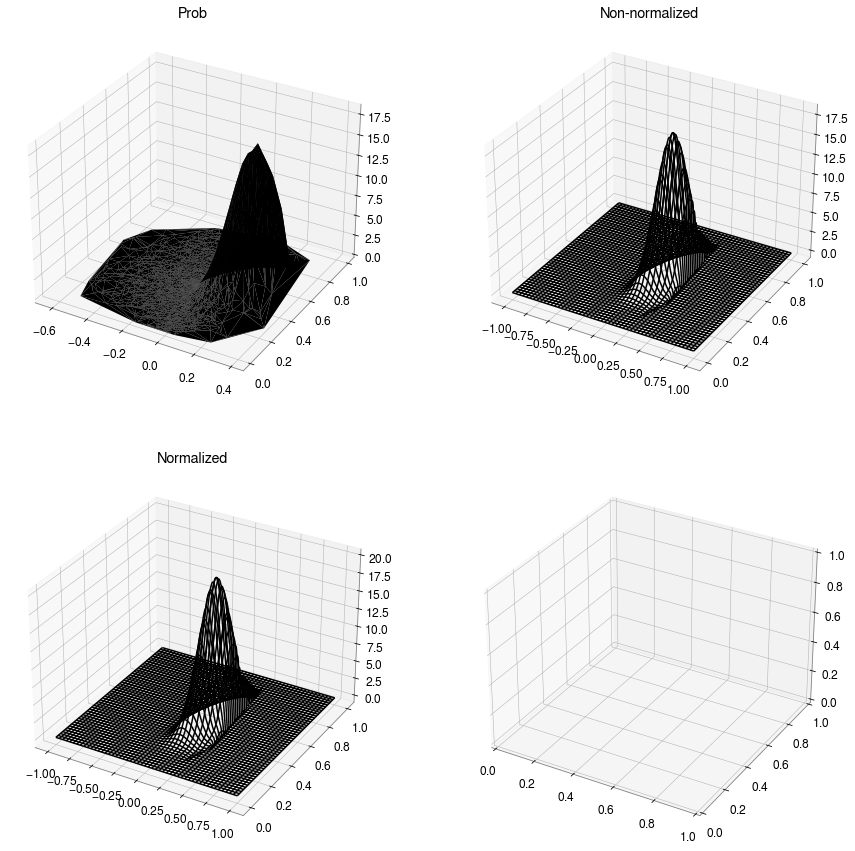

In [9]:
def prob(chieff, chip):
    # dummy values
    rho = 0.5
    mu_eff = 0.2
    mu_p = 0.5
    sigma_eff = 0.1
    sigma_p = 0.1

    # prob calculation
    part1 = 1 / ( ((2 * np.pi) * sigma_eff * sigma_p * (1 - rho**2)**0.5) )
    part2 = (-1/(2 * (1 - rho**2))) * ( ((chieff - mu_eff)/sigma_eff)**2 + ((chip - mu_p)/sigma_p)**2 - (2*rho*(chieff - mu_eff)*(chip - mu_p)/(sigma_eff * sigma_p)))
    prob =  part1 * np.exp(part2)
    
    return prob

chieff_grid, chip_grid = np.mgrid[-1:1:20000j, 0:1:10000j]

x = priors[0]["chi_eff"]
y = priors[0]["chi_p"]
points = np.column_stack([x, y])

# hull = ConvexHull(points)
# plt.plot(points[:,0], points[:,1], 'o')
# for simplex in hull.simplices:
#     plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
    
values = np.array(prob(x, y))

z = griddata(points, values, (chieff_grid, chip_grid), method = 'cubic', fill_value = 0)
print(z)

chieff_grid_array = chieff_grid[:, 0]
chip_grid_array = chip_grid[0,:]
interp_spline = RectBivariateSpline(chieff_grid_array, chip_grid_array, z)

norm = interp_spline.integral(-1, 1, 0, 1)
print(norm)

normalized_values = z/norm

fig, ax = plt.subplots(nrows = 2, ncols = 2, subplot_kw = {'projection': '3d'}, figsize = (15, 15))
ax[0][0].plot_trisurf(x, y, values, color='k')
ax[0][0].set_title("Prob")
ax[0][1].plot_wireframe(chieff_grid, chip_grid, z, color='k')
ax[0][1].set_title("Non-normalized")
ax[1][0].plot_wireframe(chieff_grid, chip_grid, normalized_values, color='k')
ax[1][0].set_title("Normalized")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0.9985649937687541


Text(0.5, 0.92, 'Normalized')

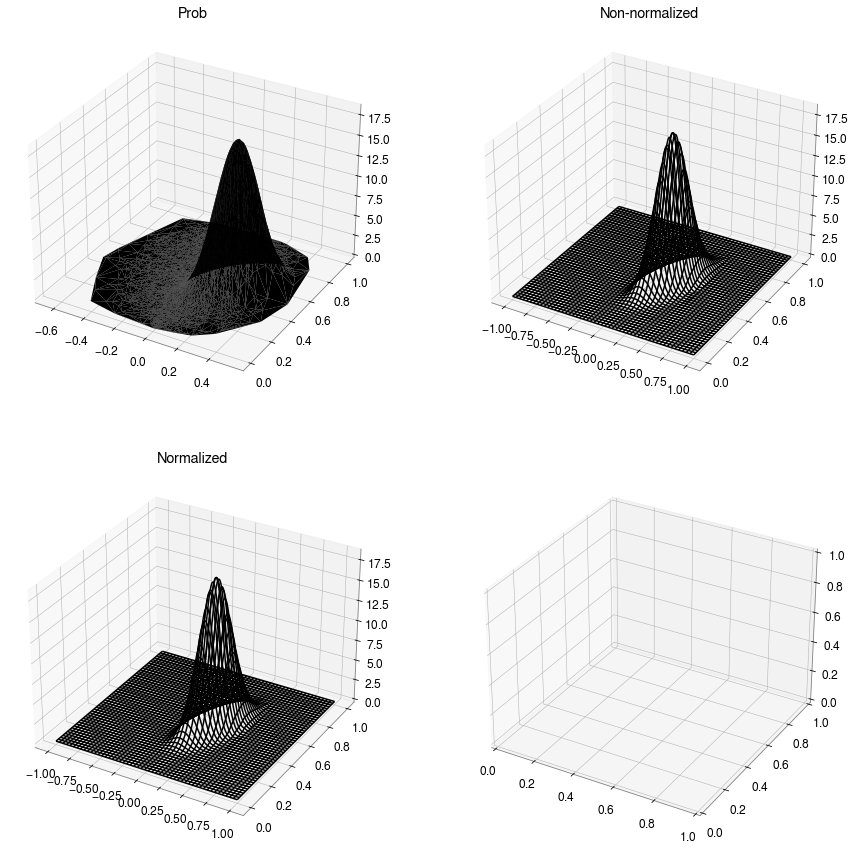

In [10]:
def prob(chieff, chip):
    # dummy values
    rho = 0.5
    mu_eff = 0.2
    mu_p = 0.5
    sigma_eff = 0.1
    sigma_p = 0.1

    # prob calculation
    part1 = 1 / ( ((2 * np.pi) * sigma_eff * sigma_p * (1 - rho**2)**0.5) )
    part2 = (-1/(2 * (1 - rho**2))) * ( ((chieff - mu_eff)/sigma_eff)**2 + ((chip - mu_p)/sigma_p)**2 - (2*rho*(chieff - mu_eff)*(chip - mu_p)/(sigma_eff * sigma_p)))
    prob =  part1 * np.exp(part2)
    
    return prob

chieff_grid, chip_grid = np.mgrid[-1:1:20000j, 0:1:10000j]

x = posteriors[1]["chi_eff"]
y = posteriors[1]["chi_p"]
points = np.column_stack([x, y])

values = np.array(prob(x, y))

#Find all the indexes where there is no nan neither in values nor in points.
nonanindex = np.invert(np.isnan(points[:,0]))*np.invert(np.isnan(points[:,1]))*np.invert(np.isnan(values))

z = griddata(np.stack((points[nonanindex,0],points[nonanindex,1]),axis=1), values[nonanindex], (chieff_grid, chip_grid), method = 'cubic', fill_value = 0)
print(z)

chieff_grid_array = chieff_grid[:, 0]
chip_grid_array = chip_grid[0,:]
interp_spline = RectBivariateSpline(chieff_grid_array, chip_grid_array, z)

norm = interp_spline.integral(-1, 1, 0, 1)
print(norm)

normalized_values = z/norm

fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': '3d'}, figsize = (15, 15))
ax[0][0].plot_trisurf(x, y, values, color='k')
ax[0][0].set_title("Prob")
ax[0][1].plot_wireframe(chieff_grid, chip_grid, z, color='k')
ax[0][1].set_title("Non-normalized")
ax[1][0].plot_wireframe(chieff_grid, chip_grid, normalized_values, color='k')
ax[1][0].set_title("Normalized")

In [17]:
def modelB(dataset, mu_eff, sigma_eff, mu_p, sigma_p, rho):

    chieff_grid, chip_grid = np.mgrid[-1:1:20000j, 0:1:10000j]

    x = dataset["chi_eff"]
    y = dataset["chi_p"]
    points = np.column_stack([x, y])
    
    # prob calculation
    part1 = 1 / ( ((2 * np.pi) * sigma_eff * sigma_p * (1 - rho**2)**0.5) )
    part2 = (-1/(2 * (1 - rho**2))) * ( ((points[:,0] - mu_eff)/sigma_eff)**2 + ((points[:,1] - mu_p)/sigma_p)**2 - (2*rho*(points[:,0] - mu_eff)*(points[:,1] - mu_p)/(sigma_eff * sigma_p)))
    values =  np.array(part1 * np.exp(part2))

    z = griddata(points, values, (chieff_grid, chip_grid), method = 'cubic', fill_value = 0)
#     print(z)

    interp_spline = RectBivariateSpline(chieff_grid[:, 0], chip_grid[0,:], z)

    norm = interp_spline.integral(-1, 1, 0, 1)
    print(norm)

    normalized_prob = xp.array(z/norm)

#     fig, ax = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection': '3d'}, figsize = (15, 15))
#     ax[0][0].plot_trisurf(x, y, values, color='k')
#     ax[0][0].set_title("Prob")
#     ax[0][1].plot_wireframe(chieff_grid, chip_grid, z, color='k')
#     ax[0][1].set_title("Non-normalized")
#     ax[1][0].plot_wireframe(chieff_grid, chip_grid, normalized_prob, color='k')
#     ax[1][0].set_title("Normalized")

    return normalized_prob

In [18]:
priorsB = PriorDict(dict(
    mu_eff = Uniform(minimum = -1, maximum = 1, latex_label ='$\\mu_{\mathrm{eff}}$'),
    sigma_eff = Uniform(minimum = 0.05, maximum = 1, latex_label ='$\\sigma_{\mathrm{eff}}$'), 
    mu_p = Uniform(minimum = 0, maximum = 1, latex_label ='$\\mu_{p}$'),
    sigma_p = Uniform(minimum = 0.05, maximum = 1, latex_label ='$\\sigma_{p}$'),
    rho = Uniform(minimum = -0.9, maximum = 0.9, latex_label ='$\\rho$')))

In [19]:
likelihoodB = gwpop.hyperpe.HyperparameterLikelihood(posteriors = priors,
                                                     hyper_prior = modelB)

In [20]:
for ii in range(10):
    likelihoodB.parameters.update(priorsB.sample())
    print(likelihoodB.parameters)
    print(likelihoodB.log_likelihood_ratio())

{'mu_eff': 0.2281444195938893, 'sigma_eff': 0.9110807242415011, 'mu_p': 0.781466801661326, 'sigma_p': 0.18801703379717466, 'rho': -0.6443304660089622}


ValueError: object __array__ method not producing an array

In [ ]:
likelihoodB.parameters.update(priorsB.sample())
likelihoodB.log_likelihood_ratio()

In [ ]:
resultB = bilby.run_sampler(likelihood = likelihoodB, priors = priorsB, sampler='dynesty', 
                            nlive = 500, label = 'gtom', outdir = 'gtom', clean = True)

In [ ]:
resultB.plot_corner(color = 'g')

### Post Processing

In [ ]:
result = bilby.core.result.read_in_result("q_grid/q_grid_result.json")

In [ ]:
resultB.posterior["log_likelihood"].max()